# Hyperparameter Optimization Of TemporalFusionTransformer

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [2]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0


In [3]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']
print(df_IT.shape)

(172, 13)


In [4]:
# Drop ACT04 column
df_IT = df_IT.drop(columns=['ACT04'])

In [5]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [6]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

target   ACT01  ACT03  ACT07  ACT09  ACT13   ACT15  \
item_id timestamp                                                        
IT01    2019-12-30  7613.0  1228.0   87.0  195.0  188.0   32.0  1817.0   
        2020-01-06   390.0    87.0   63.0    5.0    8.0    0.0     0.0   
        2020-01-13   702.0   161.0   10.0   14.0    0.0   49.0     1.0   
        2020-01-20   941.0   437.0  143.0   86.0   67.0  110.0     0.0   
        2020-01-27  1470.0   403.0  457.0  178.0  108.0   48.0     7.0   

                     ACT17   ACT32  ACT44  
item_id timestamp                          
IT01    2019-12-30  1255.0  2811.0    0.0  
        2020-01-06     0.0   227.0    0.0  
        2020-01-13     0.0   467.0    0.0  
        2020-01-20     0.0    98.0    0.0  
        2020-01-27     0.0   269.0    0.0

In [7]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

target  ACT01  ACT03  ACT07  ACT09  ACT13  ACT15  ACT17  \
item_id timestamp                                                             
IT01    2022-05-02  4074.0  788.0   29.0  396.0   30.0  111.0  515.0  145.0   
        2022-05-09   756.0  137.0    0.0  124.0    0.0    0.0    0.0    0.0   
        2022-05-16   439.0  153.0   27.0   76.0    2.0   24.0    0.0    0.0   
        2022-05-23  2078.0  452.0   28.0  387.0   57.0  158.0  506.0  138.0   
        2022-05-30  3883.0  912.0  198.0  514.0  178.0  261.0   14.0   10.0   

                     ACT32  ACT44  
item_id timestamp                  
IT01    2022-05-02  2060.0    0.0  
        2022-05-09   495.0    0.0  
        2022-05-16   157.0    0.0  
        2022-05-23   352.0    0.0  
        2022-05-30  1796.0    0.0

In [8]:
# Build predictor
predictor = TimeSeriesPredictor(
    prediction_length=12,
    freq='W-MON',
    target='target',
    path='C:\\Develop\\HPO\\TemporalFusionTransformer2',
    eval_metric='MASE'
)

In [9]:
from autogluon.common import space
from autogluon.common.utils.log_utils import add_log_to_file
from autogluon.timeseries.predictor import logger as LG

add_log_to_file("C:\\Develop\\HPO\\my.log", LG)

# Fit the model
predictor.fit(
    train_data,
    hyperparameters = {
        "TemporalFusionTransformer": {
           "hidden_dim": 32,  
           "variable_dim": 128,
           "num_heads": 4,
           "dropout_rate": space.Categorical(0.1, 0.2, 0.3, 0.4, 0.5),
           "max_epochs": space.Categorical(100, 150, 200),
           "batch_size": 64,
           "lr": 0.01,
           "early_stopping_patience" : 10
        },
    },
    hyperparameter_tune_kwargs="auto",
    refit_full=True,
    num_val_windows=5,
    random_seed=42,
)

LG.info(
        predictor.leaderboard()
)

	Trained 4 models while tuning TemporalFusionTransformer.
	-0.5348       = Validation score (-MASE)
	9523.82 s     = Total tuning time
Fitting simple weighted ensemble.
	Ensemble weights: {'TemporalFusionTransformer\\662112b2': 0.36, 'TemporalFusionTransformer\\b96591a1': 0.36, 'TemporalFusionTransformer\\e4fa7d4c': 0.27}
	-0.4621       = Validation score (-MASE)
	3.40    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training complete. Models trained: ['TemporalFusionTransformer\\662112b2', 'TemporalFusionTransformer\\b96591a1', 'TemporalFusionTransformer\\aa0c2617', 'TemporalFusionTransformer\\e4fa7d4c', 'WeightedEnsemble']
Total runtime: 9534.92 s
Best model: WeightedEnsemble
Best model score: -0.4621


In [37]:
predictor.refit_full()

<bound method TimeSeriesPredictor.refit_full of <autogluon.timeseries.predictor.TimeSeriesPredictor object at 0x000002990A6C56D0>>

In [38]:
# Make prediction on training data
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
IT01    2022-05-02  3890.746582  3041.655029  3412.249756  3541.560059   
        2022-05-09   847.096680   246.163254   429.892273   584.274902   
        2022-05-16   917.905273   296.579590   485.634949   634.324036   
        2022-05-23  1527.764893   882.234497  1137.823242  1269.312134   
        2022-05-30  3910.802734  2912.286377  3333.719727  3483.705566   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
IT01    2022-05-02  3840.325439  3890.746582  4132.985352  4110.730957   
        2022-05-09   732.152710   847.096680   993.888916  1022.331116   
        2022-05-16   776.298462   917.905273  1070.178467  1117.266968   
        2022-05-23  1401.253296  1527.764893  1666.870361  1741.288818   
        2022-05-30  3688.194580  3910.802734  4198.393555  4193.049805   

                            0.8          0.9  
item_id timestamp                             
IT01    2022-05-02  4390.406250  4712.844727  
        2022-05-09  1342.792114  1759.043823  
        2022-05-16  1381.403442  1774.636230  
        2022-05-23  1981.017334  2344.180420  
        2022-05-30  4411.204102  4817.244141

In [39]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer\e4fa7d4c,-0.161058,-0.534814,0.097769,0.068231,7049.945885,4
1,TemporalFusionTransformer\662112b2,-0.229877,-0.540790,0.086695,0.045789,7577.601844,1
2,WeightedEnsemble,-0.235637,-0.462052,0.263466,0.176975,3.397270,5
3,TemporalFusionTransformer\aa0c2617,-0.463255,-0.543879,0.089695,0.046905,6434.226672,3
4,TemporalFusionTransformer\b96591a1,-0.468664,-0.542560,0.074928,0.062956,6668.315186,2


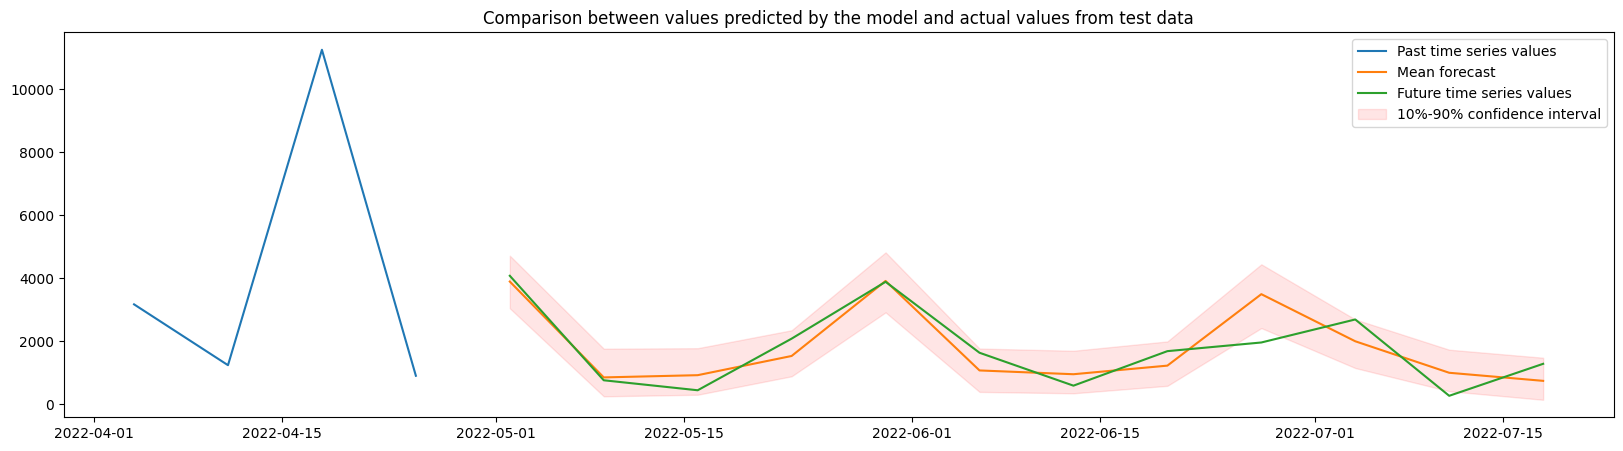

In [30]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data")

item_id = "IT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

plt.plot(y_past[-4:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()

In [31]:
# Print all row of predictions where item_id is IT01
predictions.loc['IT01']

,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
timestamp,,,,,,,,,,
2022-05-02,3890.746582,3041.655029,3412.249756,3541.560059,3840.325439,3890.746582,4132.985352,4110.730957,4390.406250,4712.844727
2022-05-09,847.096680,246.163254,429.892273,584.274902,732.152710,847.096680,993.888916,1022.331116,1342.792114,1759.043823
2022-05-16,917.905273,296.579590,485.634949,634.324036,776.298462,917.905273,1070.178467,1117.266968,1381.403442,1774.636230
2022-05-23,1527.764893,882.234497,1137.823242,1269.312134,1401.253296,1527.764893,1666.870361,1741.288818,1981.017334,2344.180420
2022-05-30,3910.802734,2912.286377,3333.719727,3483.705566,3688.194580,3910.802734,4198.393555,4193.049805,4411.204102,4817.244141
2022-06-06,1068.345703,386.858032,612.757263,800.559570,960.912170,1068.345703,1189.184814,1199.898926,1394.319336,1764.037476
2022-06-13,948.116638,342.444977,533.766357,681.667419,832.299744,948.116638,1067.825806,1100.800049,1347.208496,1693.280640
2022-06-20,1221.119751,579.659424,798.934692,939.795288,1088.368286,1221.119751,1336.045410,1384.543213,1639.930664,1989.338135
2022-06-27,3490.439941,2413.259277,2775.575684,2996.506836,3267.104980,3490.439941,3725.042480,3795.801270,3987.344238,4438.808105


In [32]:
# Sum all value of mean forecast of predictions where item_id is IT01
predictions.loc['IT01']['mean'].sum()

21548.95

In [33]:
# Sum all value of target of test_data 
test_data.loc['IT01']['target'][:12].sum()

21311.0

In [34]:
# Calculate difference betweend each prediction and actual value of test_data
diff = predictions.loc['IT01']['mean'] - test_data.loc['IT01']['target'][:12]
diff

timestamp
2022-05-02    -183.253418
2022-05-09      91.096680
2022-05-16     478.905273
2022-05-23    -550.235107
2022-05-30      27.802734
2022-06-06    -561.654297
2022-06-13     363.116638
2022-06-20    -459.880249
2022-06-27    1534.439941
2022-07-04    -692.578003
2022-07-11     731.286499
2022-07-18    -541.096985
dtype: float64

In [35]:
# Show model names
predictor.model_names() # aa0c2617 non usato per ensamble

['TemporalFusionTransformer\\662112b2',
 'TemporalFusionTransformer\\b96591a1',
 'TemporalFusionTransformer\\aa0c2617',
 'TemporalFusionTransformer\\e4fa7d4c',
 'WeightedEnsemble']

In [36]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\662112b2")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.1,
 'max_epochs': 50,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [20]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\b96591a1")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.8,
 'max_epochs': 100,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [21]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\aa0c2617")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.7,
 'max_epochs': 150,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}

In [22]:
# Show parameters of the model
model = predictor._trainer.load_model("TemporalFusionTransformer\\e4fa7d4c")  # provide the model name here
model.get_user_params()

{'hidden_dim': 32,
 'variable_dim': 128,
 'num_heads': 4,
 'dropout_rate': 0.2,
 'max_epochs': 150,
 'batch_size': 64,
 'lr': 0.01,
 'early_stopping_patience': 10}